In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Part I: Advertising is working, right ?

<img src='omer.png'/>

### Let's look at this dataset from Criteo and prove advertising is working !

In [2]:
df = pd.read_csv('criteo-small-causal-inference-problem.csv.gz', compression='gzip', nrows=10**5)

In [9]:
df.head()

,context,vertical,temperature,nb_product_views,nb_displays,nb_clicks,nb_sales
0,1,3,23,1,1,0,2
1,6,2,21,92,36,0,13
2,3,1,20,5,10,2,7
3,2,3,34,10,4,0,1
4,1,3,30,1,1,0,1


1. Examine the dataset and propose a precise definition of "advertising is working"
1. Plot nb_sales as a fonction of nb_displays. What does it say ?
1. Plot nb_sales as a function of other variables (vertical, context, temperature). What does it say ?
1. Is it enough to prove advertising is working ?

In [10]:
df.columns

Index(['context', 'vertical', 'temperature', 'nb_product_views', 'nb_displays',
       'nb_clicks', 'nb_sales'],
      dtype='object')

In [11]:
df.shape

(100000, 7)

## Part II: Are we really sure ?

<img src='marge2.jpeg'/>

1. Learn a linear regression `nb_sales ~ nb_displays` and note the coefficient of the model
1. Learn a linear regression `nb_sales ~ nb_displays, context, ...` and note the coefficients of the model
1. Is there a difference in coefficients ? Can you imagine why ?
1. What is the name of this phenomenon in causal literature ?
1. Are we still confident about our "advertising is working" hypothesis ?

In [15]:
import pandas as pd
from sklearn import linear_model

In [24]:
# QUESTION 1 
Y = df[['nb_sales']] 
X = df[['nb_displays']]
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.coef_)

Intercept: 
 [[0.10551696]]


In [25]:
# QUESTION 2
Y = df[['nb_sales']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
X = df[['nb_displays','context']]
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)

Intercept: 
 [1.14966382]


In [26]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[-0.02327535  1.19207566]]


In [28]:
df[df.context==3]

,context,vertical,temperature,nb_product_views,nb_displays,nb_clicks,nb_sales
2,3,1,20,5,10,2,7
9,3,3,27,4,12,5,3
12,3,3,30,15,9,1,3
25,3,2,28,5,9,0,5
35,3,1,19,5,9,0,8
...,...,...,...,...,...,...,...
99979,3,1,20,3,11,0,6
99984,3,1,29,6,11,0,6
99990,3,3,23,14,22,0,4
99995,3,3,28,6,9,0,6


In [ ]:
# On fait la regression par bloc 
df_context_3 = df[df.context==3]

In [31]:
A = []
A.append(1)
A

[1]

In [38]:
list_beta =[]
for i in range(1,10) :
    X = df.loc[df['context']==i,['nb_displays']]
    y = df.loc[df['context']==i,['nb_sales']]
    lm = LinearRegression() # création de l'objet régression linéaire, vide
    lm.fit(X, y)
    list_beta.append(lm.coef_)

list_beta

[array([[0.29550797]]),
 array([[0.12814228]]),
 array([[0.06843371]]),
 array([[0.03114511]]),
 array([[0.03130882]]),
 array([[0.0293237]]),
 array([[0.00718435]]),
 array([[-0.02000353]]),
 array([[0.0096811]])]

## Part III: Let's look deeper, because at least in some cases I believe it should work

<img src='lisa.png' />

1. What hypothesis can we make about the causal relation of sales and displays ? Write the different possibilites based on the observed dependence
1. Let's assume there are no unobserved confounders. Redo the regression of previous part but for each `context` separately. What do you find and what does it say wrt the "advertising is working" hypothesis ?
1. Point limitations 

## Part IV: Causal Graph Discovery (Optional)

Thanks to Marge we have now a conditional independence test (see code below). 

<img src='marge.png' />

To complete our understanding we want now to uncover the specific causal relations among our variables.

1. what can we say about `temperature - nb_sales` ?
1. what can we say about `nb_clicks - nb_sales` ?
1. Let's look at (̀`context - nb_displays - nb_clicks`). Write up the different independence tests we need to uncover the causal graph between the 3 variables. Then perform those tests using the provided code to infer the causal structure.
1. Let's look at (̀`context - nb_displays - vertical - nb_sales`). We consider the following hypothesis for the causal graph `context -> (nb_displays, vertical) -> nb_sales`. Write up the different independence tests we need to verify if this structure is faithfully describing our data. What do you conclude ?

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import percentileofscore

def modelbased_conditionnal_independence_test(
    dff,
    x_cols, y_col, z_cols, 
    model=LinearRegression(), #RandomForestRegressor(n_jobs=-1, n_estimators=30), 
    n_splits=30,
    loss=mean_squared_error,
):
    """
    Perform a conditional, model-based independence test of the form "X ind. Y | Z".
    
    Internally, estimate the goodness of fit of a model predicting P(Y|Z) and compare it to the same
    model predicting P(Y|Z,X). 
    
    H0 is the hypothesis that X is bringing additional information so the model with X as added feature
    should perform better.

    H1 is the hypothesis that all information linking X to Y is flowing through Z; so both models 
    should perform similarly.
    
    A low p-value (e.g. <.05) indicates that you cannot reject H0.
    
    Returns a tuple:
    (
      - H1 error distribution
      - H0 error
      - corresponding p-value
    )
    """
    h1_error_dist = []
    Z = dff[z_cols].values if z_cols is not None and len(z_cols) else np.ones(len(dff)).reshape(-1, 1)
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(
            Z, # without X
            dff[y_col].values.ravel(), 
            test_size=0.33, random_state=_
        )
        model.fit(X_train, y_train)
        h1_error_dist += [loss(y_test, model.predict(X_test))]
    
    X_train, X_test, y_train, y_test = train_test_split(
        np.hstack([dff[x_cols].values,Z]), # with added X
        dff[y_col].values.ravel(), 
        test_size=0.33, random_state=42
    )
    model.fit(X_train, y_train)
    h0_error = loss(y_test, model.predict(X_test))
    
    if h0_error > np.mean(h1_error_dist):
        pval = 0
    else:
        pval = percentileofscore(h1_error_dist, h0_error)/100.
    return h0_error, h1_error_dist, pval

Text(0.5, 1.0, 'p-val: 0.242')

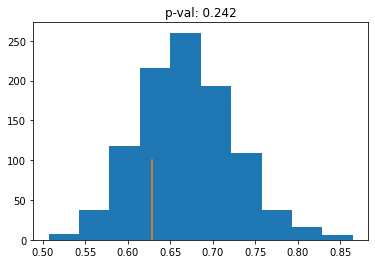

In [47]:
h1, dist, pval = modelbased_conditionnal_independence_test(
    df.head(10**4),
    ['nb_displays'], # X
    ['nb_clicks'], # Y
    ['context'], # Z
    n_splits=1000,
)
plt.hist(dist)
plt.plot((h1,h1),(0,100))
plt.title('p-val: %.3f' % pval)

Text(0.5, 1.0, 'p-val: 0.090')

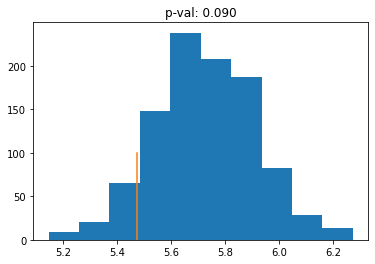

In [45]:
h1, dist, pval = modelbased_conditionnal_independence_test(
    df.head(10**4),
    ['temperature'], # X
    ['nb_sales'], # Y
    None, # Z
    n_splits=1000,
)
plt.hist(dist)
plt.plot((h1,h1),(0,100))
plt.title('p-val: %.3f' % pval)

Text(0.5, 1.0, 'p-val: 0.000')

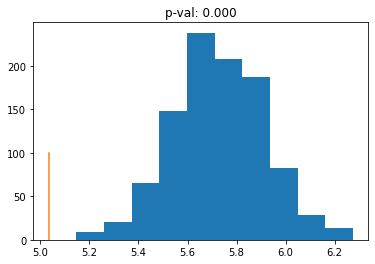

In [46]:
h1, dist, pval = modelbased_conditionnal_independence_test(
    df.head(10**4),
    ['nb_clicks'], # X
    ['nb_sales'], # Y
    None, # Z
    n_splits=1000,
)
plt.hist(dist)
plt.plot((h1,h1),(0,100))
plt.title('p-val: %.3f' % pval)

In [48]:
#CONCLUSION : si la barre est à l'interieur du graphe c'est indépendant sinon y'a une dépendance

## Conclusion

1. Write a conclusion that summarizes what you have learned
1. Discuss limitations of the approach, esp. wrt the independence test that is implemented. E.g. is it sufficient or necessary etc

In [ ]:
#How to construct data frame 
"""
Stock_Market = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
                'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]        
                }

df = pd.DataFrame(Stock_Market,columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price']) 
"""